<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

## Variational AutoEncoders

In this lab excercise you will train a Variational AutoEncoder to learn the distribution of the MNIST data. You will explore the latent space and learn how to generate new samples.

Some notation:
* $P^*$ is the true data distribution. We have some samples from this.
* $p(z)$ is a *prior* distribution over the latent space. In our model it is multivariate gaussian distribution $N(0,\mathbb{I})$.
* $E(x)$ is the encoder that accepts data points as input and outputs distributions over the latent space $Z$. The produced distribution is denoted $q_\phi(z|x)$ and is the (approximate) *posterior* distribution. In our model this is mutlivariate gaussian distribution $q_\phi(z|x) \sim N(\mu, diag(\sigma^2)$. Notes:
    1. $\phi$ are weights of the encoder network.
    2. Encoder network accepts data points as input and outputs $\mu$ and $\sigma$, which are vectors of the same length as latent space. They are used to construct the approximate posterior distribution $q_\phi(z|x)$.
* $D(z)$ is the decoder that accepts samples from the latent distribution and output parameters of the the likelihood distribution $p_\theta(x|z)$. In our model this is Bernoulli trial per each pixel $p_\theta(x|z_0) \sim Bern(p)$. Notes:
    1. $\theta$ are weights of the decoder network.
    2. Decoder network accepts sample from the posterior distribution $q_\phi(z|x)$ and outputs p, which is a matrix of the shape of the input image. Each value of the matrix is the parameter $\pi$ of the Bernoulli trial $Bern(\pi)$ for the corresponding pixel.
    3. Data points are clipped to only contain values 0 and 1 so that the model could be trained in the given setup.

Loss:
The loss that is used is called ELBO (the Evidence Lower Bound).

$$ELBO = \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x|z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big).$$

The following equation holds:


$$\log p_{\theta}(x) = ELBO + \mathbb{KL}(q_\theta(z|x) || p(z|x))$$

Maximization of ELBO is equivalent of minimization of KL-divergence between to variational posterior distribution and the true posterior distribution.

The first term of the loss is trained via stochastic gradient descent. The second term can be calculated analytically in our setup and is equal to:

$$ \mathbb{KL}\big( \mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1) \big) = \frac12 \big(\sigma^2  - \log(\sigma^2) + \mu^2 - 1 \big).$$

Tasks for the tutorial:
1. Run the pipeline and verify that VAE is training and generating decent digit representation.
2. Play with training parameters and / or network layers to better learn hidden representation of the data
3. Implement sample_latent method in the VariationalAutoEncoder class, which accepts original image as input and outputs samples from the posterior distribution $q_\phi(z|x)$.
4. Implement sample method in the VariationalAutoEncoder class, which accepts sample size and optionally samples from the prior distribution. as input and outputs samples:
    1. If samples are not avialable, take a sample $z_0 \sim p(z)$ from the prior distribution.
    2. Decode the latent $p_\theta(x|z_0) = D_\theta(z_0)$.
    3. Sample a reconstruction from the likelihood: $x_0 \sim p_\theta(x|z_0)$.
5. Explore the latent space. For each class encode a sample (>=100) of images of that class and take one parameters from the posterior distribution $q_\phi(z|x)$ per image. Visualize samples as scatter plot. Remember to color points according to image classes!
5. Sample two points $z_0, z_1$ from the prior distibution $p(z)$. Perform interpolation i.e. visualize how samples change based on points from segment ended by $z_0$ and $z_1$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms # type: ignore
from torch.utils.data import DataLoader

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 1024
test_batch_size = 1000
epochs = 15
lr = 5e-3
seed = 1
log_interval = 5
latent_size = 200

In [3]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [4]:
def visualize_data(
    images,
    labels,
    max_images, max_fig_size=(30, 30)):

    num_frames, num_channels, h, w, = images.shape
    num_frames = min(num_frames, max_images)
    ff, axes = plt.subplots(1, num_frames,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_frames == 1:
        axes = [axes]

    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        if labels is not None:
            axes[i].set_title(labels[i].item(), fontsize=28)
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

In [5]:
class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

transform=transforms.Compose([
    transforms.ToTensor(),
    Binarize()
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 102013768.24it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118412212.93it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 111847903.17it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5447677.66it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



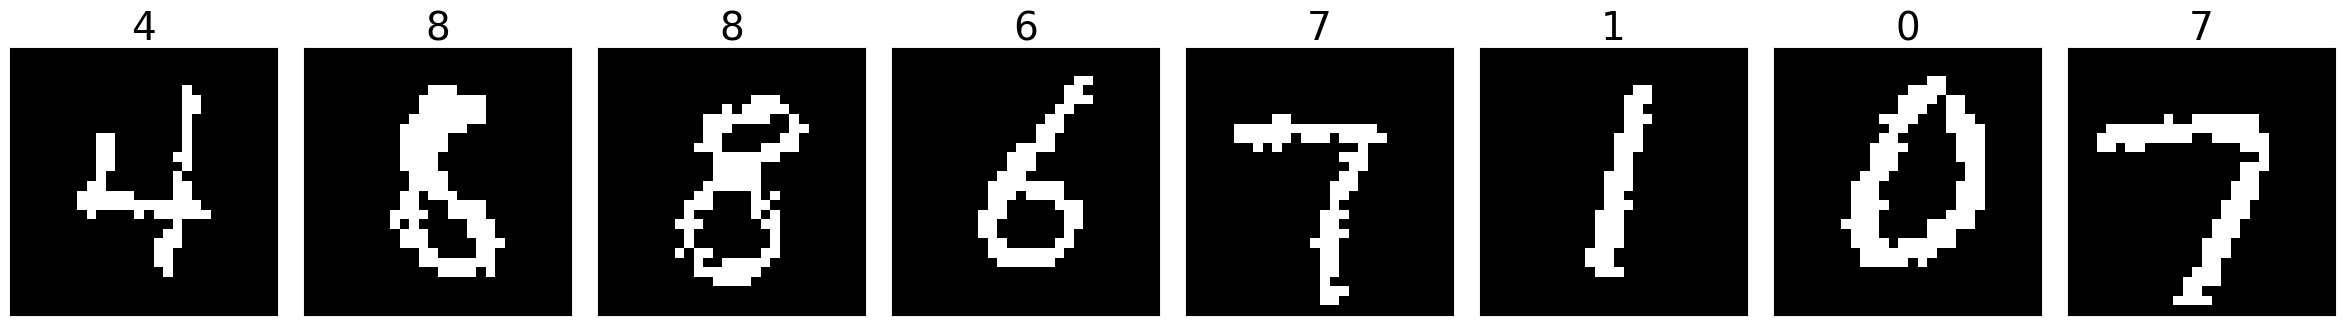

In [6]:
real_batch = next(iter(train_loader))
visualize_data(real_batch[0], real_batch[1], 8)

In [7]:
EncoderOutput = namedtuple("EncoderOutput", ["mu", "sigma"])

class Encoder(nn.Module):
  def __init__(
      self,
      linear_sizes,
      latent_size,
      *args,
      **kwargs
    ):
    super().__init__()
    self.layers = nn.ModuleList()
    for in_layer_size, out_layer_size in zip(linear_sizes, linear_sizes[1:]):
        self.layers.append(nn.Linear(in_layer_size, out_layer_size, *args, **kwargs))
        self.layers.append(nn.BatchNorm1d(out_layer_size))
        self.layers.append(nn.ReLU())

    self.last_layer_mu = nn.Linear(linear_sizes[-1], latent_size)
    self.last_layer_sigma = nn.Linear(linear_sizes[-1], latent_size)

  def forward(self, x):
    x = nn.Flatten()(x)
    for layer in self.layers:
        x = layer(x)

    mu = self.last_layer_mu(x)
    logsigma = self.last_layer_sigma(x)
    return EncoderOutput(mu, torch.log(1 + torch.exp(logsigma)))

In [8]:
class Decoder(nn.Module):
  def __init__(
      self,
      linear_sizes,
      output_size,
      *args,
      **kwargs
    ):
    super().__init__()
    self.layers = nn.ModuleList()
    for in_layer_size, out_layer_size in zip(linear_sizes, linear_sizes[1:]):
        self.layers.append(nn.Linear(in_layer_size, out_layer_size, *args, **kwargs))
        self.layers.append(nn.BatchNorm1d(out_layer_size))
        self.layers.append(nn.ReLU())

    self.last_layer = nn.Sequential(
        nn.Linear(linear_sizes[-1], output_size[0] * output_size[1]),
        nn.Sigmoid()
    )
    self.output_size = output_size

  def forward(self, z):
    for layer in self.layers:
        z = layer(z)

    x = self.last_layer(z)

    x = x.view(-1, 1, *self.output_size)
    return x

In [52]:
VariationalAutoEncoderOutput = namedtuple("VariationalAutoEncoderOutput", ["mu", "sigma", "p"])
VariationalEncoderOutput = namedtuple("VariationalEncoderOutput", ["mu", "sigma", "p"])


class VariationalAutoEncoder(nn.Module):
    def __init__(self,
                 encoder_linear_sizes,
                 latent_size,
                 decoder_linear_sizes,
                 output_size):
        super().__init__()
        self.encoder = Encoder(encoder_linear_sizes,
                               latent_size)
        self.decoder = Decoder(decoder_linear_sizes,
                               output_size)
        self.latent_size = latent_size
        self.output_size = output_size

    def forward(self, x):
        encoded = self.encoder(x)

        z = torch.normal(0., 1., size=list(encoded.mu.size())).to(device)
        z = ( z * encoded.sigma ) + encoded.mu

        decoded = self.decoder(z)
        return VariationalAutoEncoderOutput(encoded.mu, encoded.sigma, decoded)

    def sample_latent(self, x):
        # TODO: Task 3.
        encoded = self.encoder(x)

        z = torch.normal(0., 1., size=list(encoded.mu.size())).to(device)
        z = ( z * encoded.sigma ) + encoded.mu

        return VariationalEncoderOutput(encoded.mu, encoded.sigma, z)

    def sample(self, sample_size, samples=None):
        # TODO: Task 4.
        if samples is None:
          samples = torch.normal(0., 1., size=(sample_size, self.latent_size)).to(device)
        decoded = self.decoder(samples)
        return decoded

In [53]:
def KL_gaussian_loss(mu, sigma):
    return torch.mean(((sigma * sigma) - (2 * torch.log(sigma)) + (mu * mu) - 1) / 2)

def ELBO(x, p, mu, sigma):
    BCE = F.binary_cross_entropy(p, x)
    KL = KL_gaussian_loss(mu, sigma)
    return BCE + KL

In [54]:
def train(model: nn.Module, device: torch.device, train_loader: DataLoader,
          optimizer: optim.Optimizer, epoch: int, log_interval: int) -> None:
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = ELBO(data, output.p, output.mu, output.sigma)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model: nn.Module, device: torch.device, test_loader: DataLoader) -> None:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            loss = ELBO(data, output.p, output.mu, output.sigma)
            test_loss = test_loss + (loss * data.size(0))

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [55]:
vae = VariationalAutoEncoder([28 * 28, 500, 350], latent_size, [200, 350, 500], (28, 28))
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [56]:
for epoch in range(1, epochs + 1):
    train(vae, device, train_loader, optimizer, epoch, log_interval)
    test(vae, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.967252
Train Epoch: 1 [5120/60000 (8%)]	Loss: 0.346018
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.308261
Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.286203
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.270461
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.264102
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.254074
Train Epoch: 1 [35840/60000 (59%)]	Loss: 0.245717
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.243985
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.238802
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.236834
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.238096

Test set: Average loss: 0.2352

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.236835
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.233371
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.231433
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.233804
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.230231
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.230208
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.225337
Train Epoch: 2 [35840/60000 (59

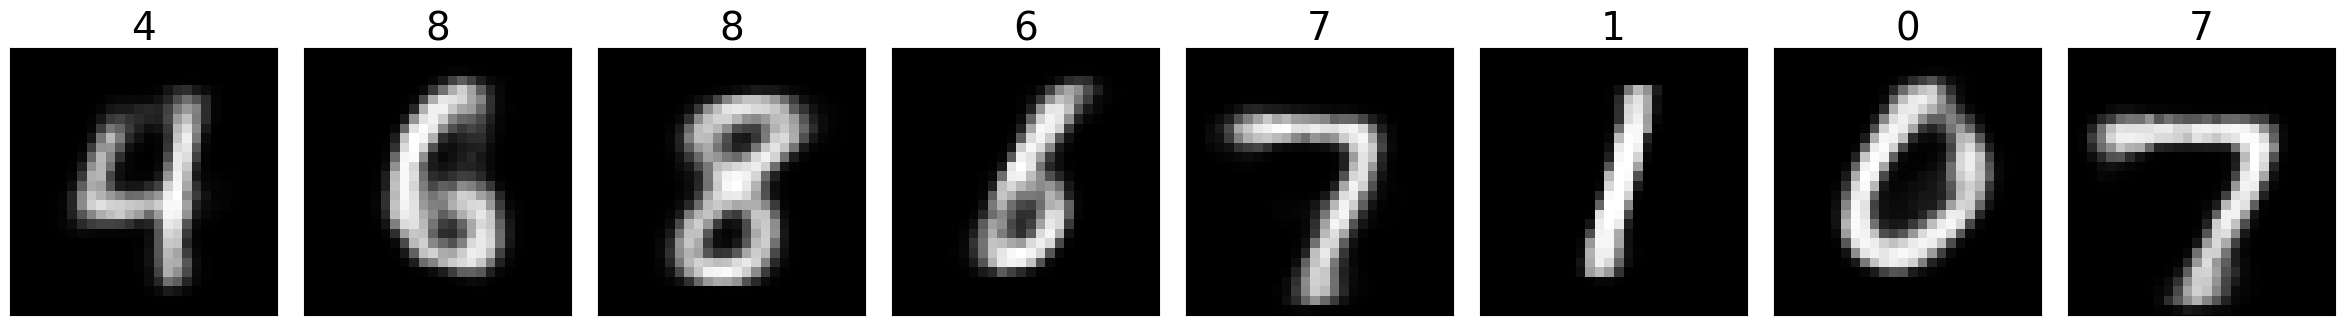

In [14]:
vae.eval()
visualize_data(vae(real_batch[0].to(device)).p.detach().cpu().numpy(), labels=real_batch[1].cpu().numpy(), max_images=8)

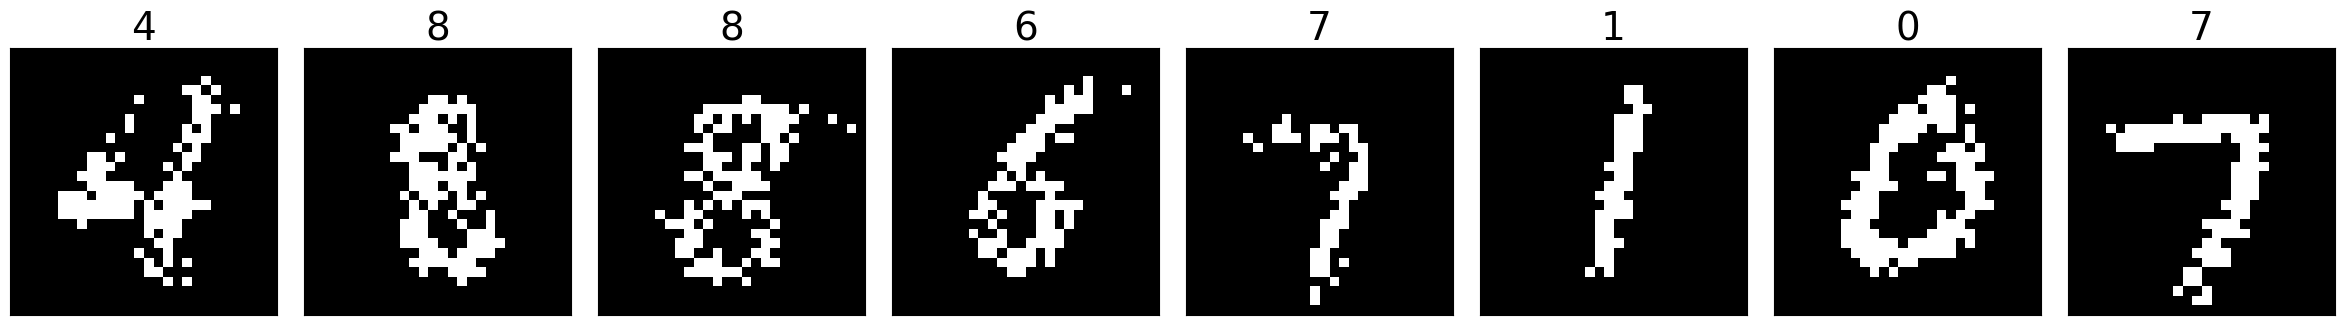

In [15]:
visualize_data(torch.bernoulli(vae(real_batch[0].to(device)).p).detach().cpu().numpy(), labels=real_batch[1].cpu().numpy(), max_images=8)

Visualization of latent space

In [96]:
# TODO
# Task 5.
labels = real_batch[1].numpy()

encoded = vae.sample_latent(real_batch[0].to(device))
points_x = encoded.mu[:, 0].detach().cpu().numpy()
points_y = encoded.mu[:, 1].detach().cpu().numpy()

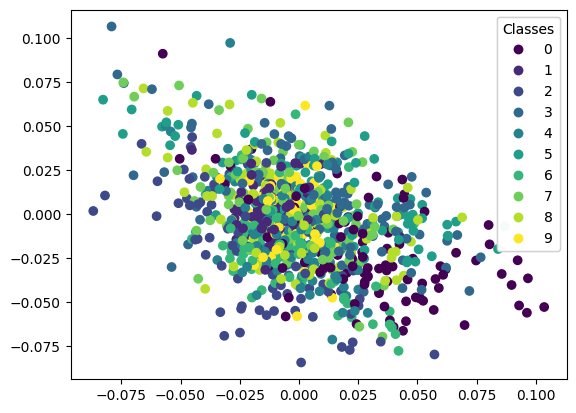

In [98]:
fig, ax = plt.subplots()

scatter = ax.scatter(x=points_x, y=points_y, c=labels)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)

plt.show()

Sample interpolation

In [50]:
#%%capture
# TODO
# Task 6.
z1 = torch.randn(size=(1, 200))
z2 = torch.randn(size=(1, 200))
vae.eval()
samples = []

for t in np.arange(0, 1, 0.1):
  z = (1-t)*z1+t*z2
  samples.append(z)

samples = torch.cat(samples).to(device)

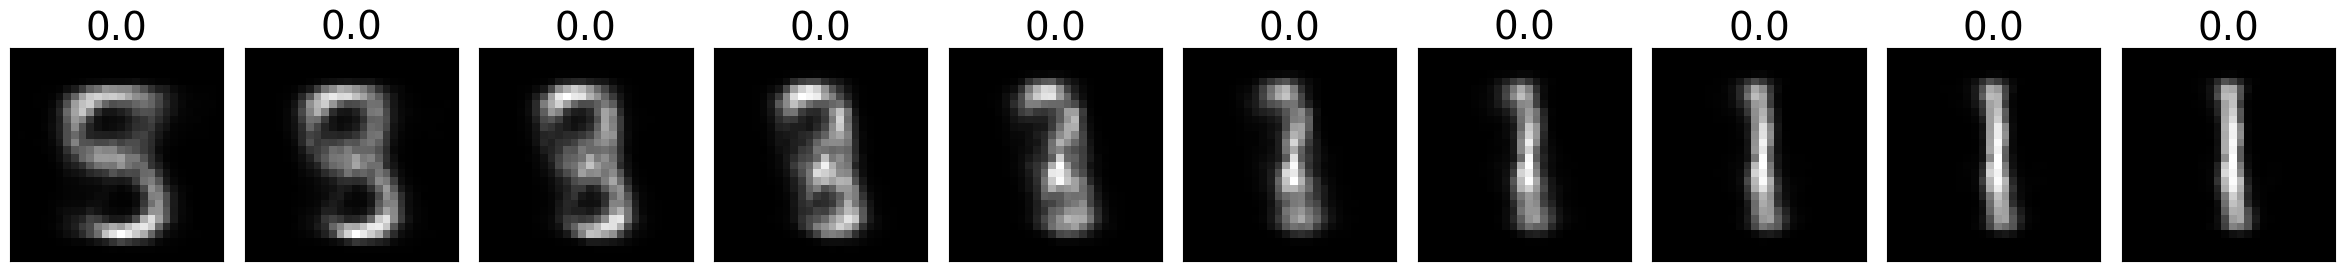

In [51]:
visualize_data(vae.sample(sample_size = 10, samples = samples).detach().cpu().numpy(), labels=torch.zeros(size=(10, 1)), max_images=10)